In [ ]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

NameError: name 'mixed_precision' is not defined

In [ ]:
train_dir = "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train" 
validation_dir = "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val"
#test_dir = "C:/Users/DELL/Desktop/Brain/Data/small/test"
test_dir = "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"

In [ ]:
model1 = ResNet50(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 8
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 4730 images belonging to 2 classes.
Found 591 images belonging to 2 classes.


In [ ]:
print(model1.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

In [ ]:
transfer_layer = model1.get_layer('conv5_block3_out')
conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [ ]:
from tensorflow.keras.models import Sequential
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
#new_model.add(Sequential(tf.keras.layers.Dense(3))) 
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.

new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=1e-5)
loss = 'binary_crossentropy'
metrics = ['categorical_accuracy']
#name="binary_crossentropy"
#metrics=[tf.keras.metrics.BinaryAccuracy(),
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

In [ ]:
steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

In [ ]:
from keras.callbacks import Callback
weights = {0:2.96,1:1}
epochs = 45

# from keras.callbacks import ModelCheckpoint
# filepath = r'/content/drive/MyDrive/Colab Notebooks/Shawon/New folder (5)/resnet-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only = True, mode='max', )

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,class_weight = weights,
                                  # callbacks = [checkpoint],
                                  )

<ipython-input-13-8ecc6b2e1d6e>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=generator_train,


Epoch 1/45
591/591 [==============================] - 3162s 5s/step - loss: 0.3913 - categorical_accuracy: 0.9181 - val_loss: 10.3577 - val_categorical_accuracy: 0.7293
Epoch 2/45
591/591 [==============================] - 92s 155ms/step - loss: 0.1895 - categorical_accuracy: 0.9571 - val_loss: 0.6160 - val_categorical_accuracy: 0.8359
Epoch 3/45
591/591 [==============================] - 89s 151ms/step - loss: 0.1588 - categorical_accuracy: 0.9645 - val_loss: 0.5748 - val_categorical_accuracy: 0.8934
Epoch 4/45
591/591 [==============================] - 90s 151ms/step - loss: 0.1093 - categorical_accuracy: 0.9732 - val_loss: 0.3809 - val_categorical_accuracy: 0.9137
Epoch 5/45
591/591 [==============================] - 89s 151ms/step - loss: 0.1091 - categorical_accuracy: 0.9751 - val_loss: 0.4361 - val_categorical_accuracy: 0.9154
Epoch 6/45
591/591 [==============================] - 90s 151ms/step - loss: 0.0771 - categorical_accuracy: 0.9814 - val_loss: 0.7041 - val_categorical_acc

In [ ]:
new_model.save_weights('F:/ResnetNetwithcs.h5')

In [ ]:
new_model1 = new_model.load_weights('F:/sc/new_codes/resnetcs_45/ResnetNetwithcs.h5')

In [ ]:
finaltestCNV_dir = "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val"
datagen_finaltestCNV_dir = ImageDataGenerator(rescale=1./255)

generator_finaltestCNV_dir = datagen_finaltestCNV_dir.flow_from_directory(directory=finaltestCNV_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_finaltestCNV_dir = generator_finaltestCNV_dir.n / batch_size
y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)

Found 592 images belonging to 2 classes.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16100\1643748472.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)


In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
#print(predicted_class_indices[0:585])

In [ ]:
unique, frequency = np.unique(predicted_class_indices, 
                              return_counts = True)
# print unique values array
print("Unique Values:", 
      unique)
  
# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [0 1]
Frequency Values: [274 318]


In [ ]:
#print(predicted_class_indices[:9])

In [ ]:
#print(predicted_class_indices[9:292])

In [ ]:
print("Accuracy = ", (20/25)*100)

Accuracy =  80.0


In [ ]:
y_true = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
              
         ]

In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_true, predicted_class_indices)

In [ ]:
#array=[[15,1],[4,5]]

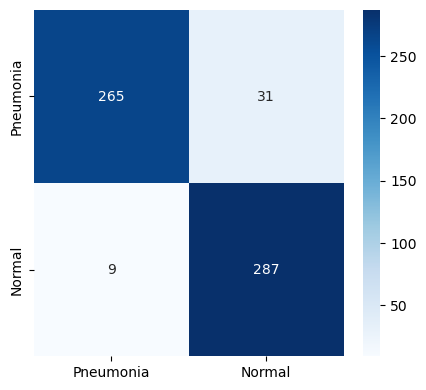

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["Pneumonia", "Normal"],
                  columns = ["Pneumonia", "Normal"])
plt.figure(figsize = (5,4.5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.savefig('F:/sc/new_codes/models/confusion.pdf')  

In [ ]:
pip install lime

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [ ]:
import lime
from lime import lime_image
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def xAI(model,img_dir):
    image = Image.open(img_dir)
    imgx = np.asarray(image)
    #print(imgx[:,:,0].shape)
    imgx = image.resize((224, 224))
    img = np.asarray(imgx)
    img = img/255
    img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
    img2[:,:,0] = img # same value in each channel
    img2[:,:,1] = img
    img2[:,:,2] = img
    #print(img2.shape)
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(img2, new_model.predict, labels=["Normal", "Pneumonia"],top_labels=2, hide_color=0,num_samples=1000)
    #plt.imshow(img)
    image, mask = explanation.get_image_and_mask(
             model.predict(img2.reshape((1,224,224,3))).argmax(axis=1)[0],
        
             positive_only=False,
        #num_features=10,
             hide_rest=False)
    plt.axis ('off')
    plt.imshow(mark_boundaries(image, mask))
    plt.savefig('F:/sc/new_codes/models/rclime124true.png')
    plt.savefig('F:/sc/new_codes/models/rclime124true.pdf')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 314ms/step


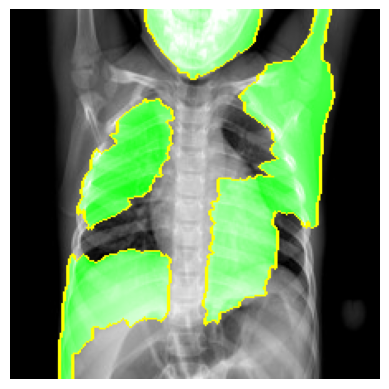

In [ ]:
#0-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/NORMAL/IM-0177-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 334ms/step


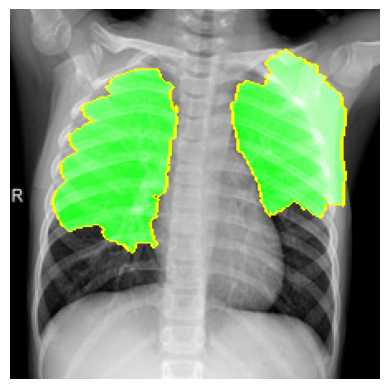

In [ ]:
#0-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/NORMAL/IM-0147-0001.jpeg")

In [ ]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

NameError: name 'image_path' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 340ms/step


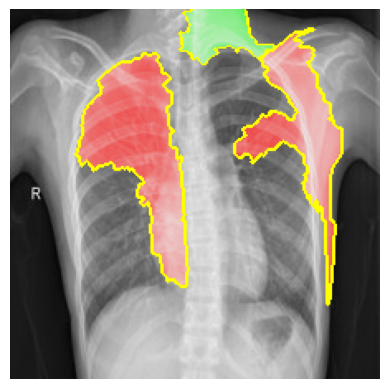

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/NORMAL/IM-0028-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 269ms/step


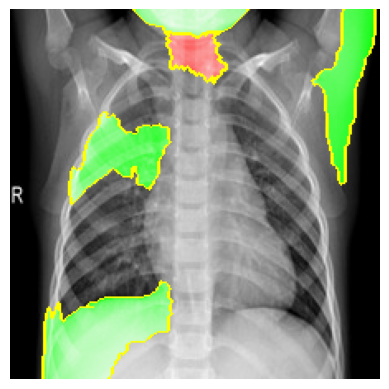

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/NORMAL/NORMAL2-IM-0323-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 245ms/step


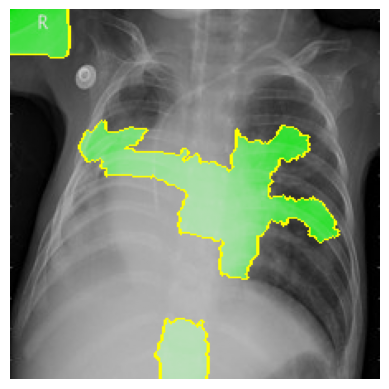

In [ ]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/PNEUMONIA/person6_bacteria_22.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 298ms/step


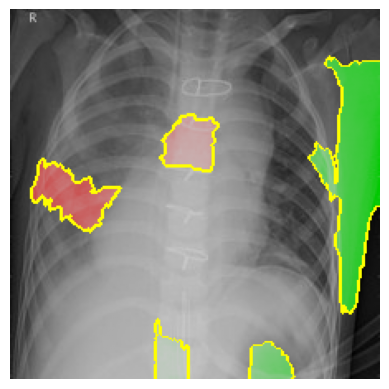

In [ ]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/PNEUMONIA/person2_bacteria_4.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 276ms/step


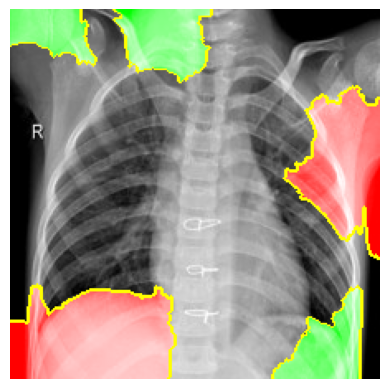

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/PNEUMONIA/person21_bacteria_73.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 270ms/step


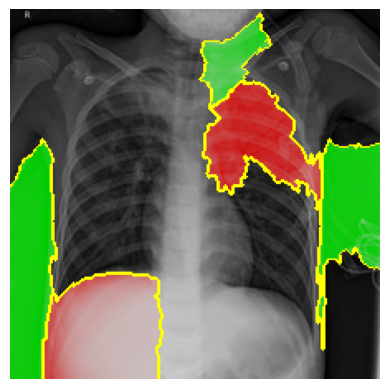

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/val/PNEUMONIA/person101_virus_188.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 274ms/step


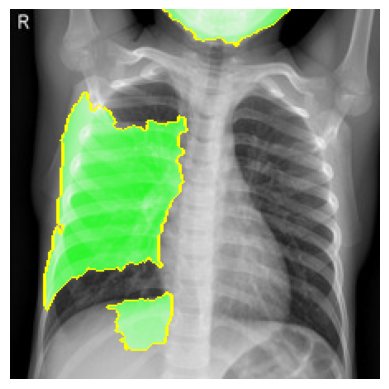

In [ ]:
#0-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/IM-0063-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 281ms/step


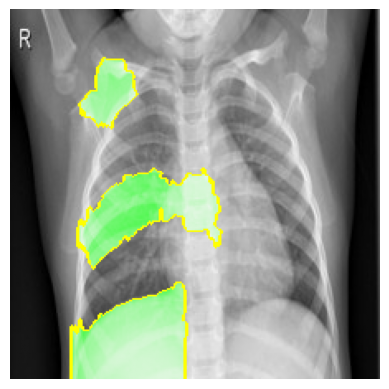

In [ ]:
#0-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/IM-0105-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 270ms/step


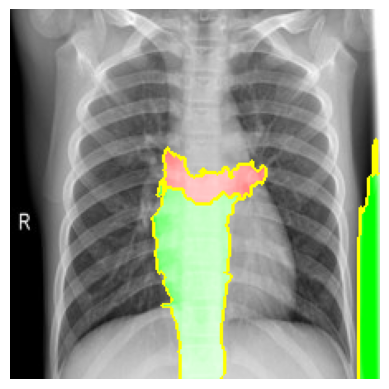

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/IM-0071-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 270ms/step


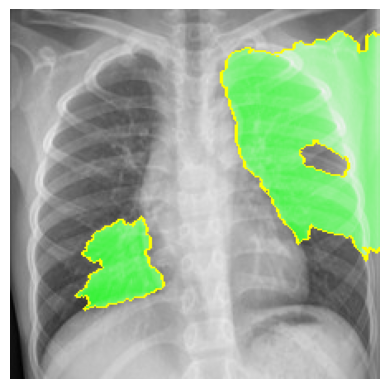

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/IM-0006-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 273ms/step


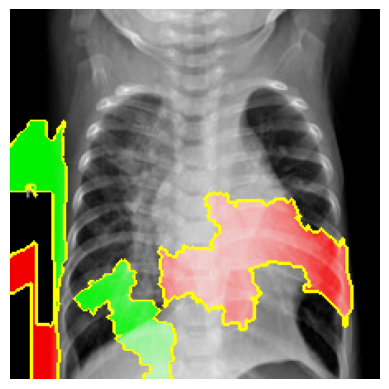

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pneumonia/person61_bacteria_296.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 244ms/step


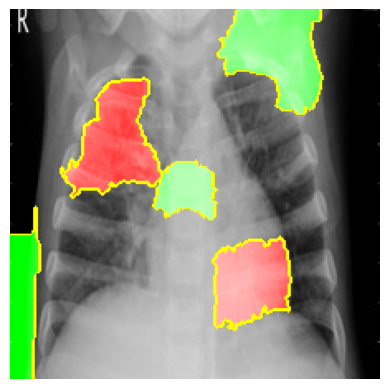

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pneumonia/person22_virus_54.jpeg")

In [ ]:
from PIL import Image
# Open the image form working directory
image = Image.open('F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/PNEUMONIA/person76_bacteria_372.jpeg')
image = image.resize((224, 224))
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

data = np.asarray(image)

data = data/255

data2 = np.zeros( ( np.array(data).shape[0], np.array(data).shape[1], 3 ) )
data2[:,:,0] = data # same value in each channel
data2[:,:,1] = data
data2[:,:,2] = data
print(data2.shape)
y = new_model.predict(data2.reshape(1,224,224,3))

predicted_class_indices=np.argmax(y,axis=1)
print(predicted_class_indices)

None
(224, 224)
L
(224, 224, 3)
1/1 [==============================] - 0s 138ms/step
[1]


In [ ]:
Epoch 1/30
585/585 [==============================] - 4868s 8s/step - loss: 0.3607 - categorical_accuracy: 0.9242 - val_loss: 6.0102 - val_categorical_accuracy: 0.6229
Epoch 2/30
585/585 [==============================] - 5922s 10s/step - loss: 0.1913 - categorical_accuracy: 0.9571 - val_loss: 1.7822 - val_categorical_accuracy: 0.6809
Epoch 3/30
585/585 [==============================] - 4733s 8s/step - loss: 0.1264 - categorical_accuracy: 0.9708 - val_loss: 1.3094 - val_categorical_accuracy: 0.8157
Epoch 4/30
585/585 [==============================] - 4566s 8s/step - loss: 0.1089 - categorical_accuracy: 0.9757 - val_loss: 0.5247 - val_categorical_accuracy: 0.8993
Epoch 5/30
585/585 [==============================] - 4577s 8s/step - loss: 0.0753 - categorical_accuracy: 0.9816 - val_loss: 0.8832 - val_categorical_accuracy: 0.8601
Epoch 6/30
585/585 [==============================] - 4658s 8s/step - loss: 0.0841 - categorical_accuracy: 0.9829 - val_loss: 1.8686 - val_categorical_accuracy: 0.7850
Epoch 7/30
585/585 [==============================] - 4306s 7s/step - loss: 0.0750 - categorical_accuracy: 0.9834 - val_loss: 0.8883 - val_categorical_accuracy: 0.8737
Epoch 8/30
585/585 [==============================] - 4326s 7s/step - loss: 0.0769 - categorical_accuracy: 0.9840 - val_loss: 0.9328 - val_categorical_accuracy: 0.8618
Epoch 9/30
585/585 [==============================] - 4311s 7s/step - loss: 0.0606 - categorical_accuracy: 0.9870 - val_loss: 1.2762 - val_categorical_accuracy: 0.8294
Epoch 10/30
585/585 [==============================] - 15521s 27s/step - loss: 0.0523 - categorical_accuracy: 0.9887 - val_loss: 1.9527 - val_categorical_accuracy: 0.7747
Epoch 11/30
585/585 [==============================] - 4462s 8s/step - loss: 0.0447 - categorical_accuracy: 0.9904 - val_loss: 1.3236 - val_categorical_accuracy: 0.8498
Epoch 12/30
585/585 [==============================] - 4951s 8s/step - loss: 0.0456 - categorical_accuracy: 0.9902 - val_loss: 1.7881 - val_categorical_accuracy: 0.8140
Epoch 13/30
585/585 [==============================] - 6964s 12s/step - loss: 0.0339 - categorical_accuracy: 0.9919 - val_loss: 1.4582 - val_categorical_accuracy: 0.8379
Epoch 14/30
585/585 [==============================] - 4859s 8s/step - loss: 0.0358 - categorical_accuracy: 0.9925 - val_loss: 1.7086 - val_categorical_accuracy: 0.8259
Epoch 15/30
585/585 [==============================] - 5359s 9s/step - loss: 0.0403 - categorical_accuracy: 0.9917 - val_loss: 1.9183 - val_categorical_accuracy: 0.8072
Epoch 16/30
585/585 [==============================] - 4668s 8s/step - loss: 0.0376 - categorical_accuracy: 0.9923 - val_loss: 1.1535 - val_categorical_accuracy: 0.8515
Epoch 17/30
585/585 [==============================] - 6617s 11s/step - loss: 0.0272 - categorical_accuracy: 0.9930 - val_loss: 1.2358 - val_categorical_accuracy: 0.8532
Epoch 18/30
585/585 [==============================] - 4786s 8s/step - loss: 0.0173 - categorical_accuracy: 0.9968 - val_loss: 2.7586 - val_categorical_accuracy: 0.7765
Epoch 19/30
585/585 [==============================] - 5175s 9s/step - loss: 0.0251 - categorical_accuracy: 0.9945 - val_loss: 1.9631 - val_categorical_accuracy: 0.8345
Epoch 20/30
585/585 [==============================] - 6851s 12s/step - loss: 0.0264 - categorical_accuracy: 0.9947 - val_loss: 1.8754 - val_categorical_accuracy: 0.8396
Epoch 21/30
585/585 [==============================] - 4531s 8s/step - loss: 0.0358 - categorical_accuracy: 0.9917 - val_loss: 1.9815 - val_categorical_accuracy: 0.8259
Epoch 22/30
585/585 [==============================] - 4684s 8s/step - loss: 0.0216 - categorical_accuracy: 0.9951 - val_loss: 1.4181 - val_categorical_accuracy: 0.8771
Epoch 23/30
585/585 [==============================] - 4542s 8s/step - loss: 0.0230 - categorical_accuracy: 0.9949 - val_loss: 1.8266 - val_categorical_accuracy: 0.8396
Epoch 24/30
585/585 [==============================] - 4457s 8s/step - loss: 0.0273 - categorical_accuracy: 0.9949 - val_loss: 1.8279 - val_categorical_accuracy: 0.8345
Epoch 25/30
585/585 [==============================] - 4196s 7s/step - loss: 0.0330 - categorical_accuracy: 0.9945 - val_loss: 2.0951 - val_categorical_accuracy: 0.8225
Epoch 26/30
585/585 [==============================] - 4231s 7s/step - loss: 0.0191 - categorical_accuracy: 0.9955 - val_loss: 1.8487 - val_categorical_accuracy: 0.8276
Epoch 27/30
585/585 [==============================] - 4094s 7s/step - loss: 0.0223 - categorical_accuracy: 0.9955 - val_loss: 1.9403 - val_categorical_accuracy: 0.8328
Epoch 28/30
585/585 [==============================] - 6895s 12s/step - loss: 0.0092 - categorical_accuracy: 0.9977 - val_loss: 1.5697 - val_categorical_accuracy: 0.8396
Epoch 29/30
585/585 [==============================] - 4858s 8s/step - loss: 0.0083 - categorical_accuracy: 0.9987 - val_loss: 1.6644 - val_categorical_accuracy: 0.8413
Epoch 30/30
570/585 [============================>.] - ETA: 2:03 - loss: 0.0190 - categorical_accuracy: 0.9954

SyntaxError: invalid syntax (<ipython-input-46-c86872cb10ca>, line 1)

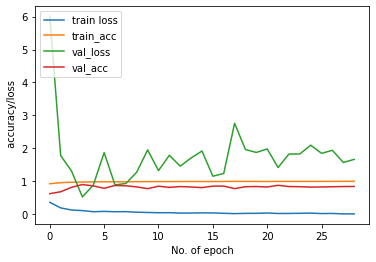

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.3607 ,0.1913,0.1264,0.1089,0.0753,0.0841 , 0.0750 ,0.0769 ,0.0606,0.0523 , 0.0447 ,0.0456 ,0.0339,0.0358, 0.0403 ,0.0376 , 0.0272, 0.0173 , 0.0251,0.0264 ,0.0358 , 0.0216, 0.0230 ,0.0273, 0.0330 ,0.0191 , 0.0223 ,0.0092, 0.0083 ])#loss
plt.plot([ 0.9242,0.9571 ,0.9708 ,0.9757,0.9816 ,0.9829 ,0.9834 ,0.9840 ,0.9870,0.9887 ,0.9904,0.9902,0.9919 , 0.9925 ,0.9917, 0.9923 ,0.9930, 0.9968 ,0.9945, 0.9947,0.9917,0.9951,0.9949, 0.9949 , 0.9945 , 0.9955 ,0.9955 , 0.9977 ,0.9987])#categorical_accuracy
plt.plot([ 6.0102,1.7822,1.3094 ,0.5247,0.8832,1.8686,0.8883,0.9328,1.2762 ,1.9527,1.3236,1.7881 ,1.4582 ,1.7086,1.9183,1.1535,1.2358,2.7586,1.9631,1.8754,1.9815,1.4181,1.8266 ,1.8279 ,2.0951, 1.8487 , 1.9403 ,1.5697,1.6644 ])#val_loss
plt.plot([0.6229, 0.6809,0.8157,0.8993, 0.8601,0.7850, 0.8737,0.8618,0.8294,0.7747,0.8498,0.8140,0.8379,0.8259,0.8072,0.8515,0.8532, 0.7765,0.8345,0.8396,0.8259, 0.8771,0.8396,0.8345,0.8225, 0.8276,0.8328,0.8396,0.8413])#val_categorical_accuracy
#plt.title('model accuracy and loss')
plt.ylabel(' accuracy/loss')
plt.xlabel('No. of epoch')
plt.legend(['train loss','train_acc', 'val_loss','val_acc'], loc='upper left')
plt.show()

In [ ]:
loss: 0.6435 - categorical_accuracy: 0.6578 - val_loss: 4.3284 - val_categorical_accuracy: 0.5000
loss: 0.3592 - categorical_accuracy: 0.8439 - val_loss: 4.7390 - val_categorical_accuracy: 0.5000
loss: 0.3245 - categorical_accuracy: 0.8740 - val_loss: 1.9577 - val_categorical_accuracy: 0.5433
loss: 0.3080 - categorical_accuracy: 0.8802 - val_loss: 1.1540 - val_categorical_accuracy: 0.6400
loss: 0.2663 - categorical_accuracy: 0.8961 - val_loss: 0.6151 - val_categorical_accuracy: 0.8000
loss: 0.2520 - categorical_accuracy: 0.8977 - val_loss: 0.2536 - val_categorical_accuracy: 0.9067
loss: 0.2271 - categorical_accuracy: 0.9157 - val_loss: 0.2361 - val_categorical_accuracy: 0.9000
loss: 0.2131 - categorical_accuracy: 0.9245 - val_loss: 0.1594 - val_categorical_accuracy: 0.9300
loss: 0.1933 - categorical_accuracy: 0.9245 - val_loss: 0.1425 - val_categorical_accuracy: 0.9500
loss: 0.2106 - categorical_accuracy: 0.9257 - val_loss: 0.1735 - val_categorical_accuracy: 0.9267
loss: 0.1738 - categorical_accuracy: 0.9320 - val_loss: 0.1375 - val_categorical_accuracy: 0.9433
loss: 0.1721 - categorical_accuracy: 0.9378 - val_loss: 0.1329 - val_categorical_accuracy: 0.9533
loss: 0.1692 - categorical_accuracy: 0.9395 - val_loss: 0.1305 - val_categorical_accuracy: 0.9500
loss: 0.1360 - categorical_accuracy: 0.9528 - val_loss: 0.1414 - val_categorical_accuracy: 0.9467
loss: 0.1312 - categorical_accuracy: 0.9578 - val_loss: 0.1156 - val_categorical_accuracy: 0.9567
loss: 0.1544 - categorical_accuracy: 0.9462 - val_loss: 0.1109 - val_categorical_accuracy: 0.9533
loss: 0.1440 - categorical_accuracy: 0.9520 - val_loss: 0.1138 - val_categorical_accuracy: 0.9567
loss: 0.1257 - categorical_accuracy: 0.9595 - val_loss: 0.1102 - val_categorical_accuracy: 0.9567
loss: 0.1233 - categorical_accuracy: 0.9574 - val_loss: 0.0947 - val_categorical_accuracy: 0.9633
loss: 0.1101 - categorical_accuracy: 0.9620 - val_loss: 0.0968 - val_categorical_accuracy: 0.9633
loss: 0.1130 - categorical_accuracy: 0.9595 - val_loss: 0.0929 - val_categorical_accuracy: 0.9633
loss: 0.1194 - categorical_accuracy: 0.9583 - val_loss: 0.1030 - val_categorical_accuracy: 0.9533
loss: 0.0946 - categorical_accuracy: 0.9679 - val_loss: 0.0954 - val_categorical_accuracy: 0.9567
loss: 0.0888 - categorical_accuracy: 0.9708 - val_loss: 0.0853 - val_categorical_accuracy: 0.9633
loss: 0.0861 - categorical_accuracy: 0.9737 - val_loss: 0.0768 - val_categorical_accuracy: 0.9733
loss: 0.0933 - categorical_accuracy: 0.9708 - val_loss: 0.0928 - val_categorical_accuracy: 0.9667
loss: 0.0877 - categorical_accuracy: 0.9670 - val_loss: 0.0843 - val_categorical_accuracy: 0.9667
loss: 0.0805 - categorical_accuracy: 0.9708 - val_loss: 0.0717 - val_categorical_accuracy: 0.9733
loss: 0.0704 - categorical_accuracy: 0.9762 - val_loss: 0.0762 - val_categorical_accuracy: 0.9767
loss: 0.0861 - categorical_accuracy: 0.9712 - val_loss: 0.0718 - val_categorical_accuracy: 0.9700
loss: 0.0716 - categorical_accuracy: 0.9741 - val_loss: 0.0655 - val_categorical_accuracy: 0.9700

SyntaxError: invalid syntax (<ipython-input-48-8873b5e9f04f>, line 1)

  0%|          | 0/1000 [00:12<?, ?it/s]

1/1 [==============================] - 0s 316ms/step


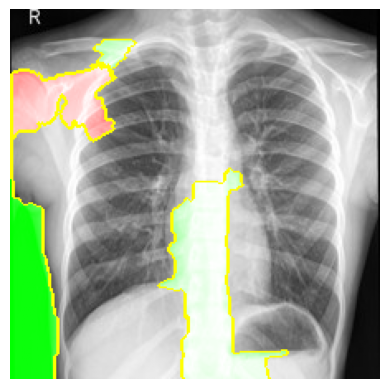

In [ ]:
#0-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/IM-0036-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 290ms/step


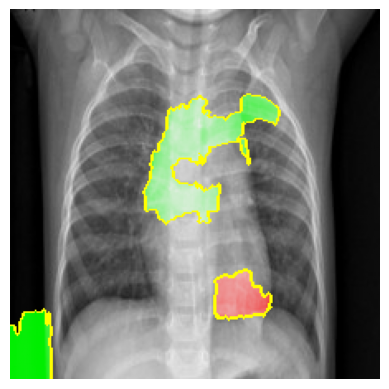

In [ ]:
#0-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/IM-0065-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 344ms/step


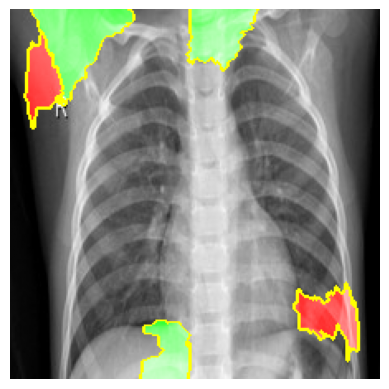

In [ ]:
#actual-0
#predict-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/IM-0091-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 256ms/step


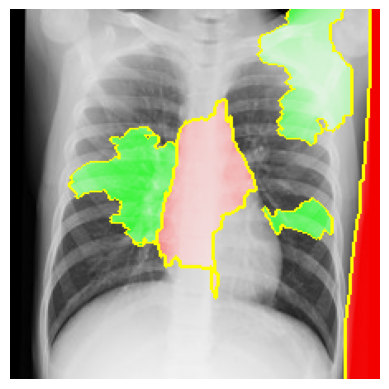

In [ ]:
#actual-0
#predict-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL/NORMAL2-IM-0105-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 397ms/step


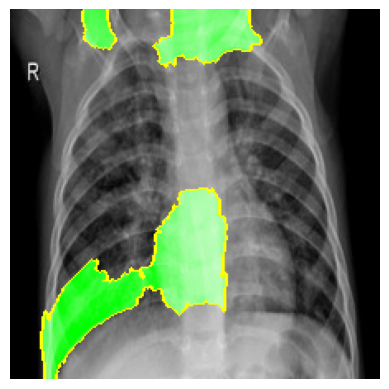

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pneumonia/person19_virus_50.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 338ms/step


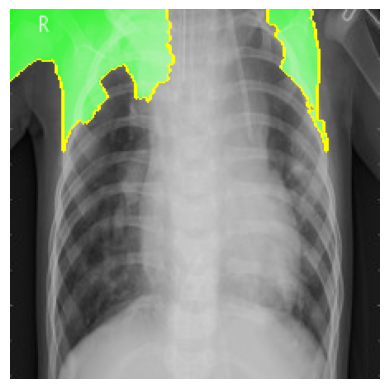

In [ ]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pneumonia/person103_bacteria_488.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 277ms/step


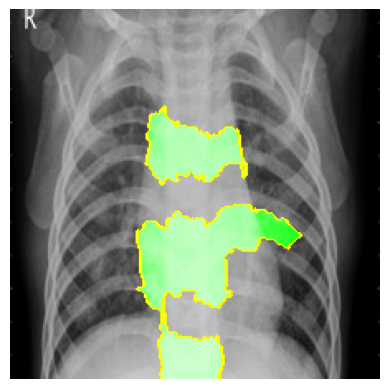

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pneumonia/person39_virus_85.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 255ms/step


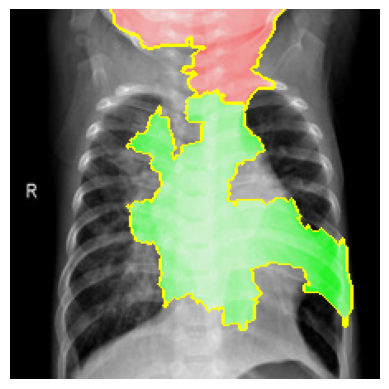

In [ ]:
#actual-1
#predict-1CORRect
xAI(new_model, "F:/sc/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pneumonia/person61_bacteria_296.jpeg")

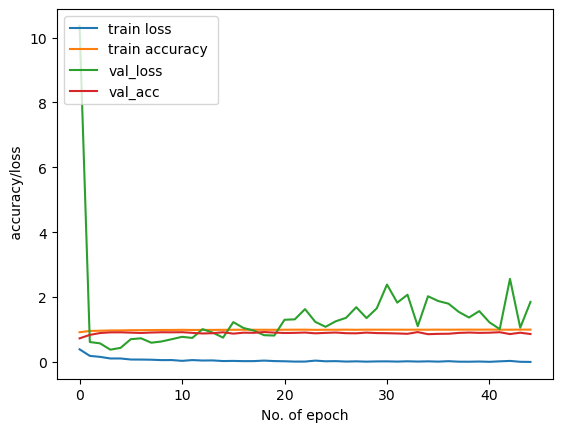

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.3913,0.1895,0.1588,0.1093,0.1091,0.0771,0.0758,0.0712,0.0586,0.0604,0.0359,0.0599,0.0460,0.0492,0.0295,0.0343,0.0270,0.0280,0.0441,0.0289,0.0233,0.0132,0.0140,0.0434,0.0229,0.0273,0.0139,0.0211,0.0114,0.0187,0.0203,0.0132,0.0224,0.0139,0.0209,0.0123,0.0256,0.0107,0.0092,0.0155,0.0060,0.0212,0.0342,0.0069,0.0030])#loss
plt.plot([0.9181,0.9571,0.9645,0.9732,0.9751,0.9814,0.9825,0.9848,0.9871,0.9882,0.9918,0.9878,0.9897,0.9897,0.9924,0.9941,0.9945,0.9939,0.9935,0.9930,0.9951,0.9966,0.9970,0.9913,0.9949,0.9943,0.9970,0.9939,0.9975,0.9964,0.9966,0.9970,0.9954,0.9973,0.9956,0.9977,0.9956,0.9975,0.9981,0.9973,0.9992,0.9962,0.9962,0.9985,0.9992])#categorical_accuracy
plt.plot([10.3577,0.6160,0.5748,0.3809,0.4361,0.7041,0.7305,0.5947,0.6331,0.7034,0.7767,0.7423,1.0128,0.9053,0.7519,1.2288,1.0483,0.9686,0.8269,0.8157,1.3020,1.3152,1.6301,1.2379,1.0851,1.2555,1.3615,1.6894,1.3544,1.6539,2.3868,1.8304,2.0734,1.1053,2.0266,1.8794,1.7982,1.5452,1.3713,1.5696,1.2222,1.0149,2.5633,1.0579,1.8527])#val_loss
plt.plot([0.7293,0.8359,0.8934,0.9137,0.9154,0.9052,0.8951,0.9086,0.9171,0.9154,0.9188,0.8985,0.8799,0.8883,0.9171,0.8748,0.9036,0.9002,0.9239,0.9069,0.8943,0.8985,0.9086,0.8849,0.8985,0.9086,0.8883,0.8849,0.9069,0.8917,0.8883,0.8799,0.8697,0.9222,0.8579,0.8680,0.8714,0.8968,0.9086,0.8985,0.9036,0.9188,0.8613,0.9036,0.8629])#val_categorical_accuracy
#plt.title('model accuracy and loss')
plt.ylabel(' accuracy/loss')
plt.xlabel('No. of epoch')
plt.legend(['train loss','train accuracy ', 'val_loss','val_acc'], loc='upper left')
plt.show()